<a href="https://colab.research.google.com/github/HwangSiyeon/ESAA_homework/blob/main/ESAA_HW_0617_CNN_CatsAndDogs_CNNClassificationKagglePractice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras CNN Dog or Cat Classification

In [48]:
# Import Library
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("/content/drive/MyDrive/ESAA_OB_HW/ESAA_Project/Input"))

['sampleSubmission.csv', 'test1.zip', 'train.zip']


In [10]:
!unzip -qq '/content/drive/MyDrive/ESAA_OB_HW/ESAA_Project/Input/train.zip' -d '/content/'

In [11]:
!unzip -qq '/content/drive/MyDrive/ESAA_OB_HW/ESAA_Project/Input/test1.zip' -d '/content/'

In [49]:
# Define Constants
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

## Prepare Traning Data

In [13]:
filenames = os.listdir("/content/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [14]:
df.head()

filename  category
0  dog.10867.jpg         1
1   dog.6113.jpg         1
2   cat.8399.jpg         0
3   cat.5107.jpg         0
4   cat.3441.jpg         0

In [15]:
df.tail()

filename  category
24995  cat.11535.jpg         0
24996  cat.10729.jpg         0
24997   cat.6814.jpg         0
24998   cat.1828.jpg         0
24999  dog.10189.jpg         1

<Axes: xlabel='category'>

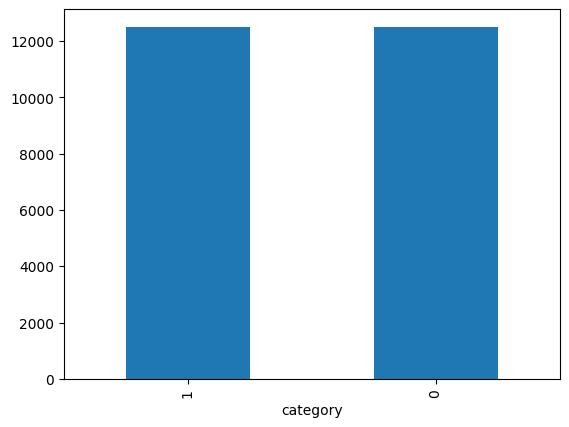

In [16]:
# See Total In Count
df['category'].value_counts().plot.bar()

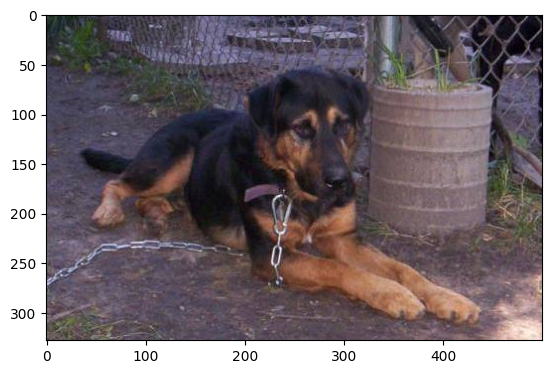

In [18]:
# See sample image
sample = random.choice(filenames) # 무작위로 1개 고르기
image = load_img("/content/train/"+sample)
plt.imshow(image)

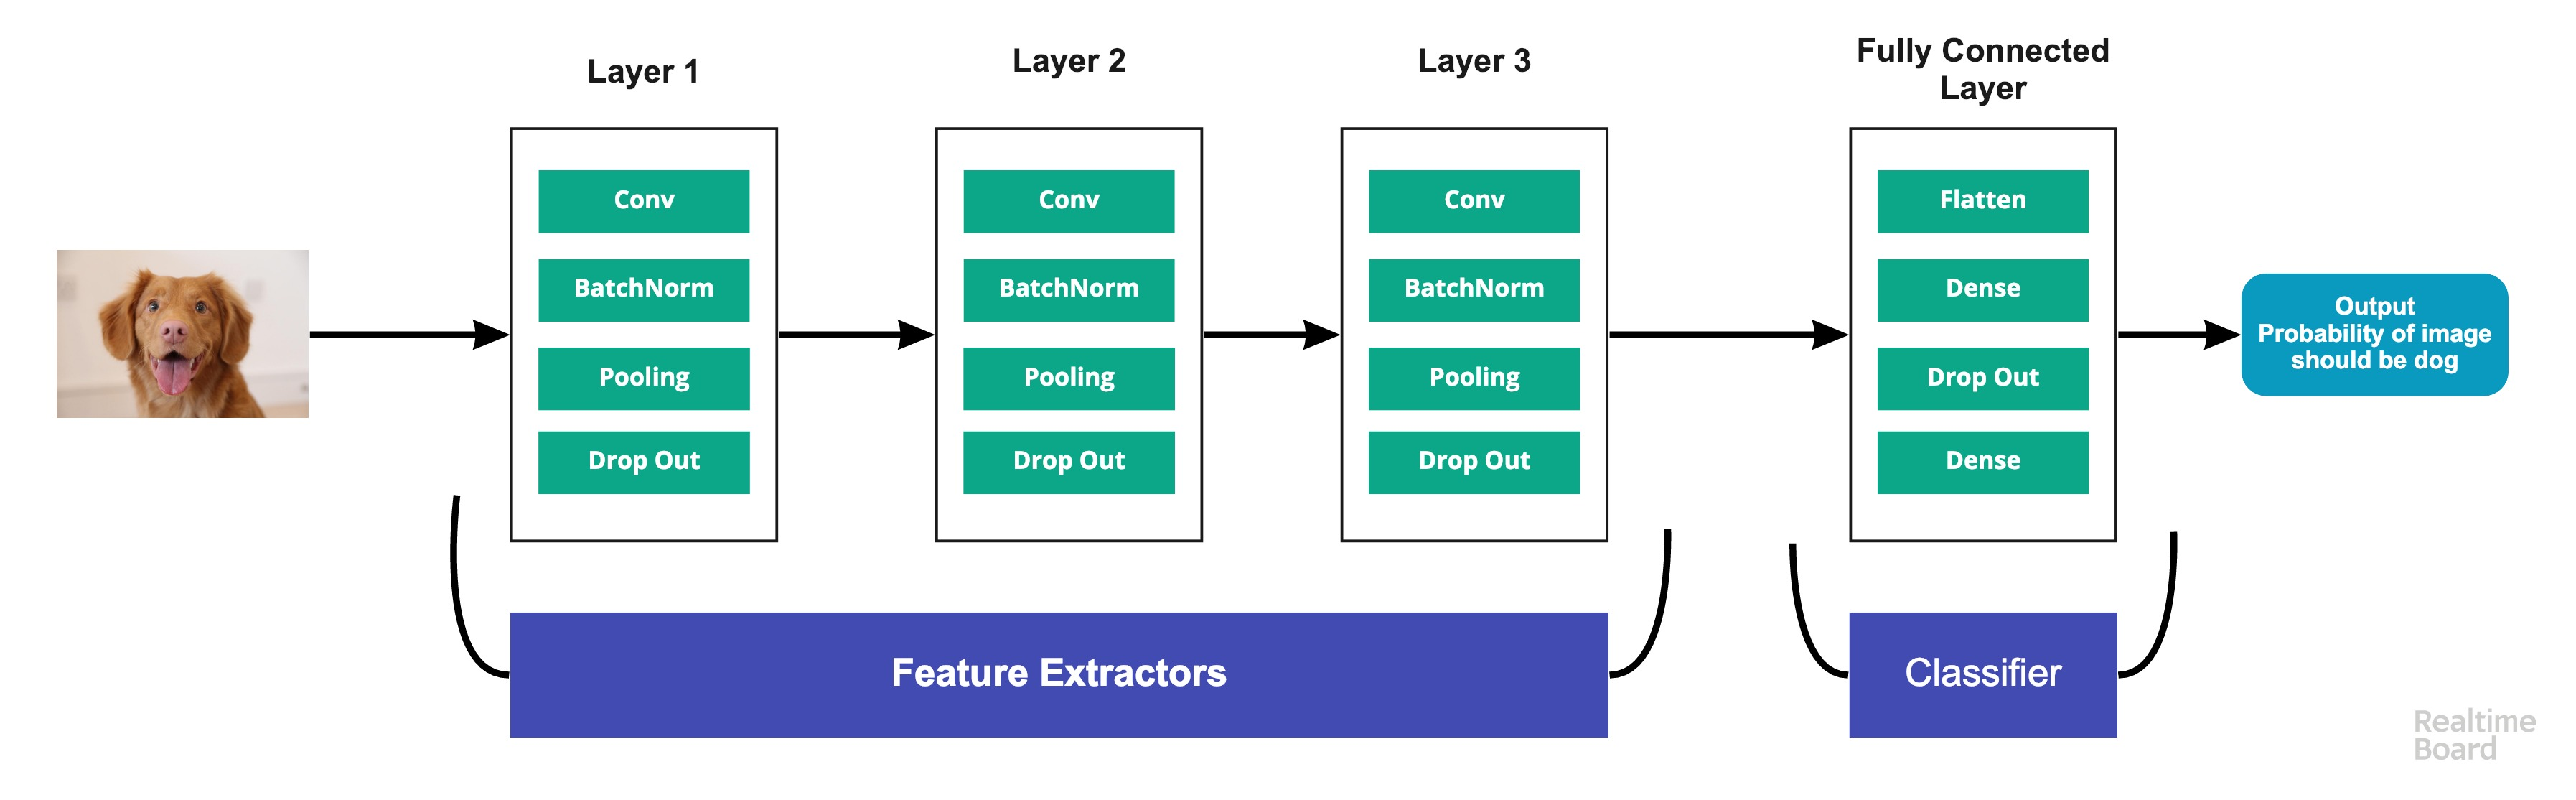

- Input Layer: 이미지 데이터. 64x64 = 4096의 이미지의 경우 (4096,1) array로 convert된다.
- Conv Layer: 이미지에서 feature map추출
- Pooling Layer: convolution 후 feature map 축소
- Fully Connected Layer: MLP
- Output Layer: predict

## Build Model


In [59]:
# Build Model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32,(3,3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_8 (Bat  (None, 126, 126, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 63, 63, 32)        0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 63, 63, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_9 (Bat  (None, 61, 61, 64)       

In [20]:
# Callbacks
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [21]:
# Early Stop
earlystop = EarlyStopping(patience=10)

In [22]:
# Learning Rate Reduction
# 2 step동안 accracy가 늘어나지 않으면 lr(learning rate)를 줄인다.
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=1, factor=0.5, min_lr=0.00001)

In [23]:
callbacks = [earlystop, learning_rate_reduction]

# Prepare Data
- class_mode="categorical" 을 이용해 이미지 제너레이터를 사용하므로 column을 string으로 바꿔야 한다. 그러면 image generateor는 column을 one-hot-encoding하여 분류에 적합하게 변환한다.
- 1은 강아지 0은 고양이로 변환

In [24]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})

In [25]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

<Axes: xlabel='category'>

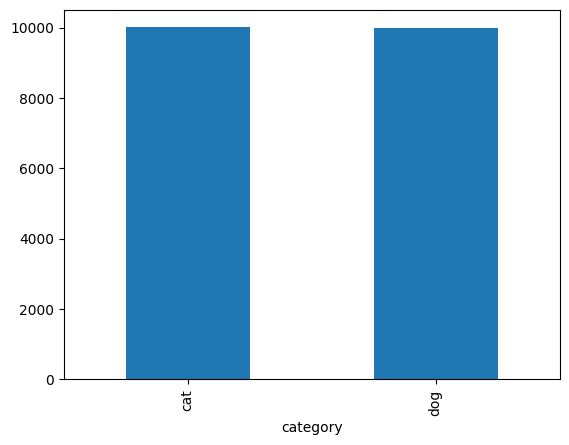

In [26]:
train_df['category'].value_counts().plot.bar()

<Axes: xlabel='category'>

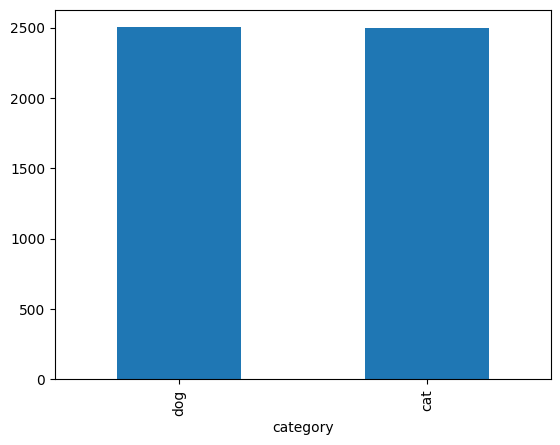

In [27]:
validate_df['category'].value_counts().plot.bar()

In [28]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [39]:
# Traning Generator
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    "/content/train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 20000 validated image filenames belonging to 2 classes.


In [40]:
# Validation Generator
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "/content/train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 5000 validated image filenames belonging to 2 classes.


## See how our generator work

In [42]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df,
    "/content/train/",
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


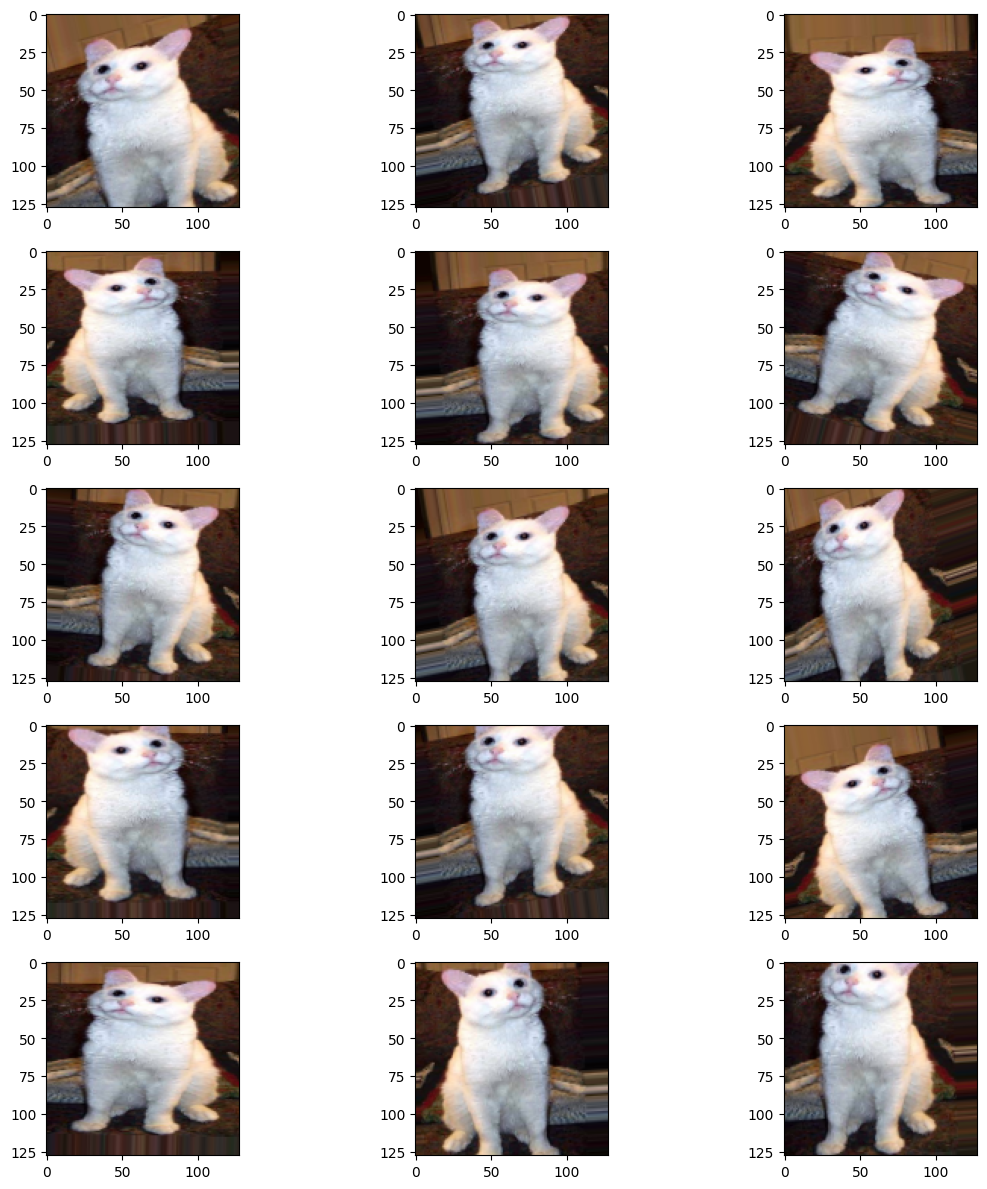

In [57]:
import cv2

plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()



## Fit Model

In [61]:
epochs=2
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

<ipython-input-61-22afd05db2af>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/2
1333/1333 [==============================] - ETA: 0s - loss: 0.7266 - accuracy: 0.6314

1333/1333 [==============================] - 1459s 1s/step - loss: 0.7266 - accuracy: 0.6314 - val_loss: 0.5632 - val_accuracy: 0.7127 - lr: 0.0010
Epoch 2/2
1333/1333 [==============================] - ETA: 0s - loss: 0.5673 - accuracy: 0.7130

1333/1333 [==============================] - 1361s 1s/step - loss: 0.5673 - accuracy: 0.7130 - val_loss: 0.5347 - val_accuracy: 0.7423 - lr: 0.0010


## Save Model

In [62]:
model.save_weights("model.h5")

## Virtualize Training

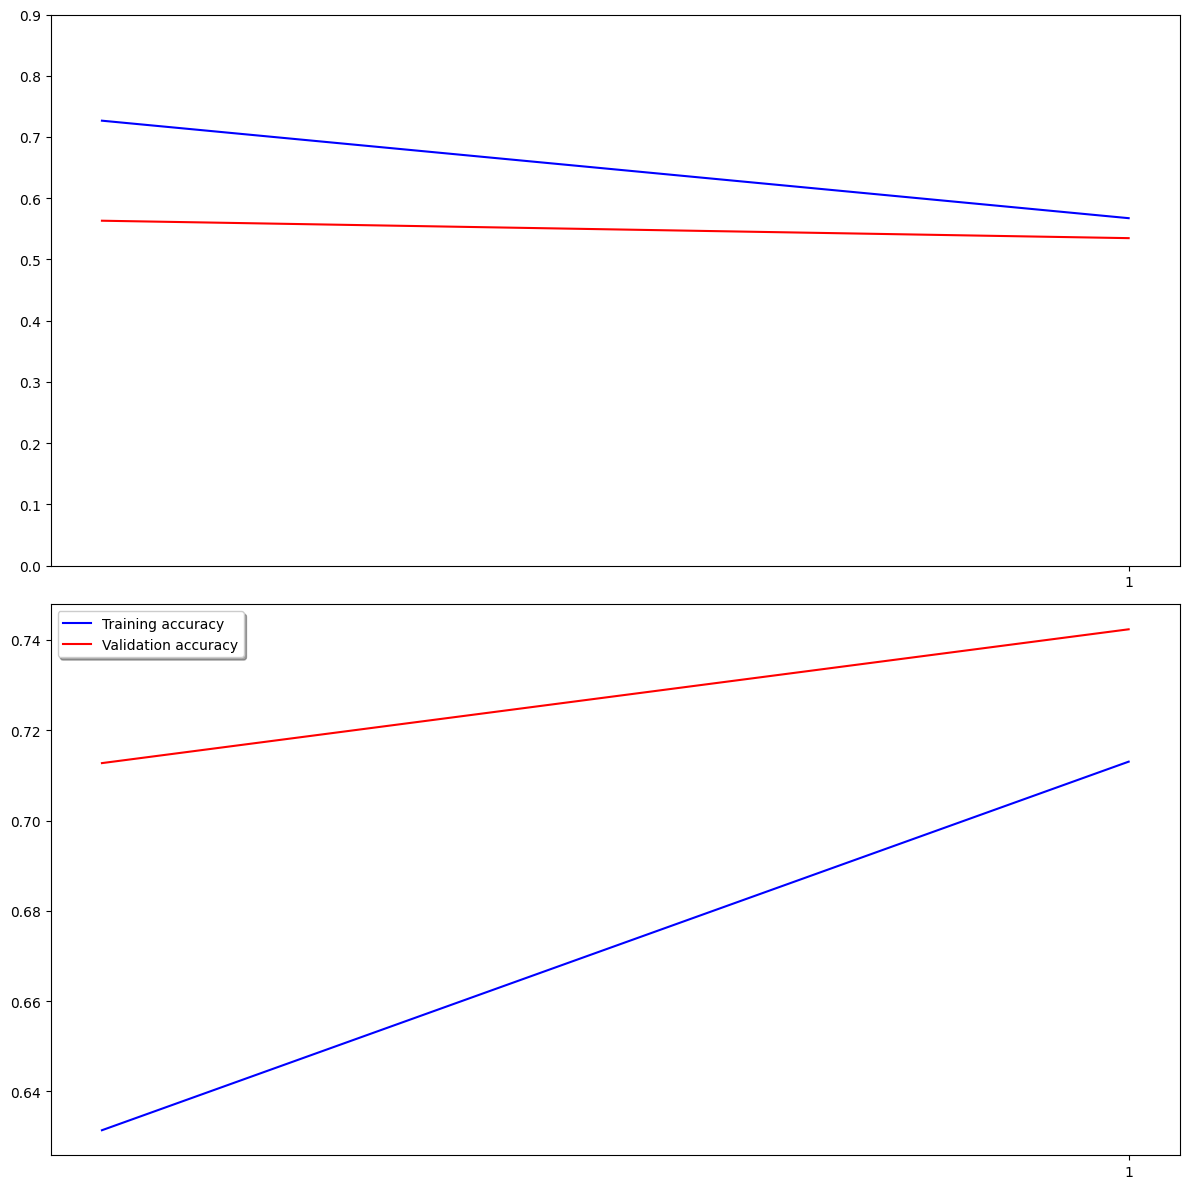

In [64]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

## Prepare Testing Data

In [66]:
test_filenames = os.listdir("/content/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

## Create Testing Generator

In [67]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df,
    "/content/test1/",
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


## Predict

In [68]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

<ipython-input-68-52619fd72ccc>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))


In [69]:
# Softmax로 얻은 확률값을 argmax하여 0과 1로 된 y값을 얻는다.
test_df['category'] = np.argmax(predict, axis=-1)

In [70]:
# predict된 카테고리를 train_generator.class_indices를 이용하여 generator class로 전환
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [71]:
# 1은 개, 0은 고양이로 카테고리를 매핑함.
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

<Axes: xlabel='category'>

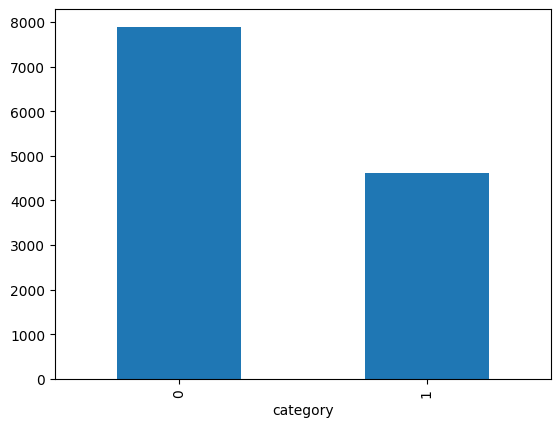

In [72]:
# Virtaulize Result - test데이터에서 고양이/개 분류비율 확인
test_df['category'].value_counts().plot.bar()

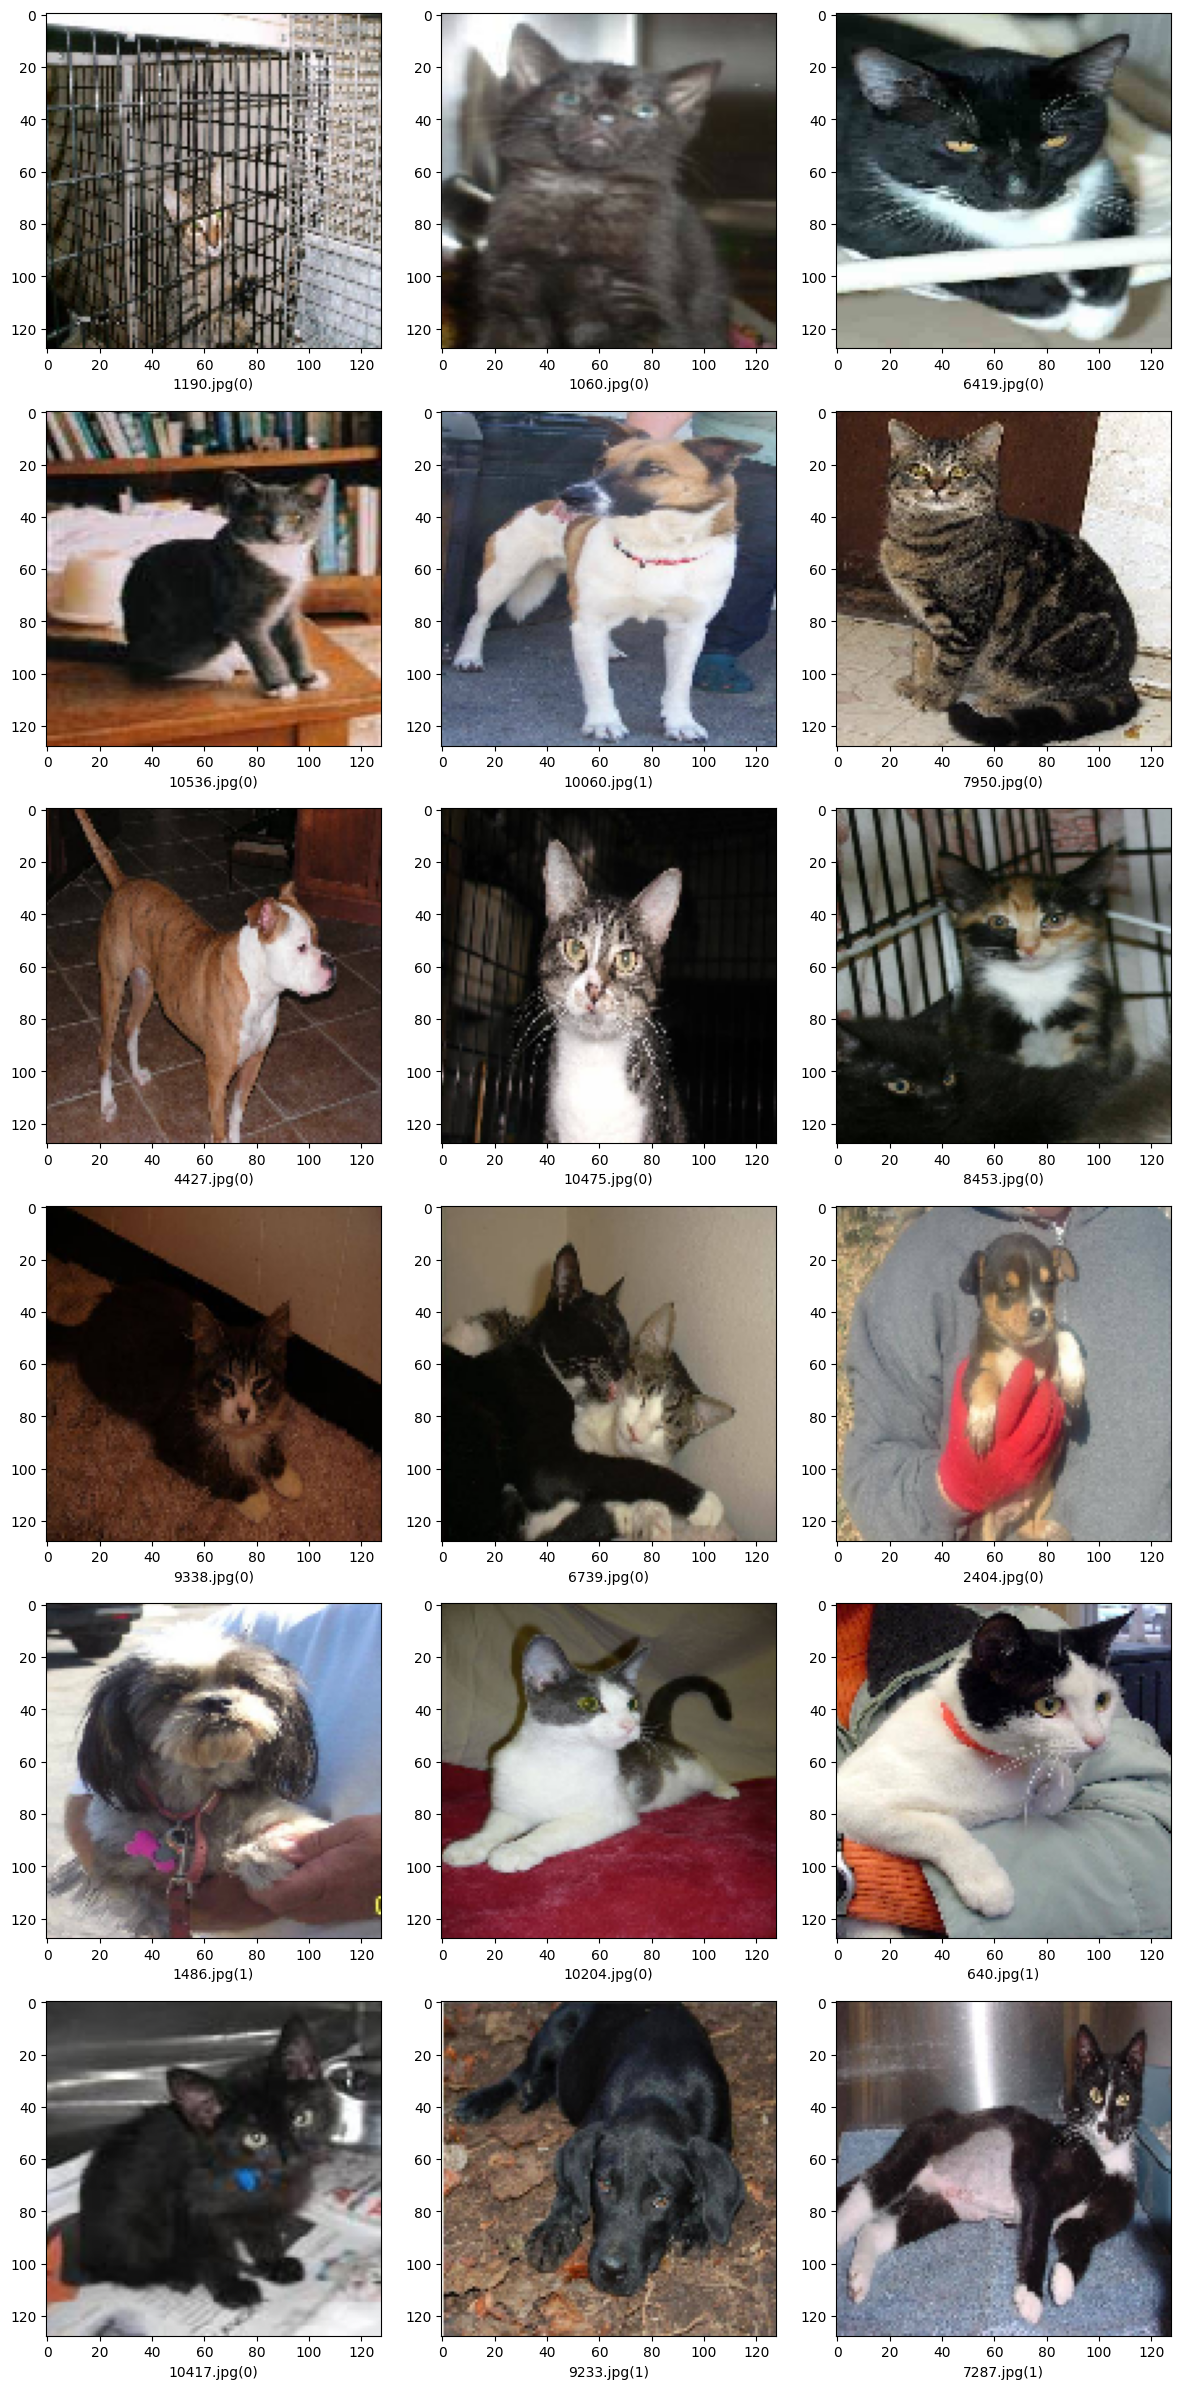

In [73]:
# See predicted result with images
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [74]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)